In [1]:
## Find the exact bounds for \alpha_i for a variance normalized (not mean) distr
p, n, u, K = var('p, n, u, K')
# TODO: FIX ME
errorTerm = 0.56 / (sqrt(p) * (1-p) ^ (1.5) * sqrt(n))
mean = 0#n*p / sqrt(p * (1 - p) * n)
guassian = 1 / sqrt(2 * pi) * e ^ (-0.5 * (u - mean)^2)
# eqSmaller = -errorTerm + (1/u + 1/u^3) * guassian <= K / n
eqLarger = errorTerm + (1/u) * guassian == K / n
view((solve([eqLarger], u)))

In [5]:

# Denormalize
view(uSimUpperBound * sqrt(n * p * (1-p)) + n * p)

## The actual thing

In [1]:
u, M, K, p, DegBit, DegStab = var('u, M, K, p, NTS, NTQ')

pPrime = 0.5 - 0.5 * (1-2*p)^DegStab
mean = DegBit * DegStab * (pPrime)
stdDev = sqrt(DegBit * DegStab * pPrime * (1 - pPrime))
gaussian = 1 / sqrt(2 * pi) * exp(-0.5 * u^2)
errorTerm = 0.56 / sqrt(DegBit * DegStab)

# TODO: THIS ERROR TERM IS GIVING ME SOME TROUBLE...
eqLarger = errorTerm + (1/u) * gaussian == K / M
view(solve([eqLarger], u))

## Using Sage and Order Statistics to plot expected G_k
1. Using the definition of a binomial distribution, get the largest `u` such that Pr[G_k >= u] >= K / N
2. Get the expected value of E_i
3. Plot the differences etc.

<>:36: DeprecationWarning: invalid escape sequence \d
<>:36: DeprecationWarning: invalid escape sequence \d
<ipython-input-41-e68f98f67b8e>:36: DeprecationWarning: invalid escape sequence \d
  legend_label=f"({deg_bit}, {deg_stable}) graph, $\delta = {delta}$, $p = {error_probability}$, $M = {M}$")


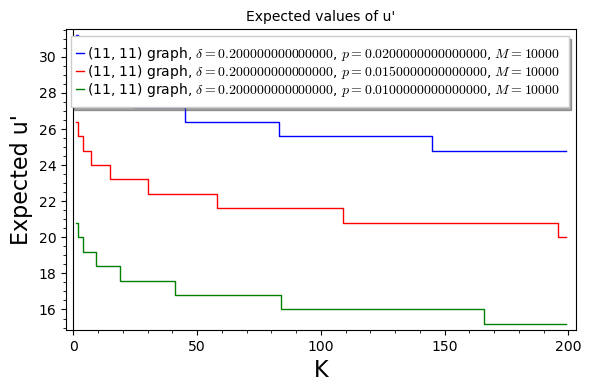

In [41]:
# NCDF refers to 1 - cdf here (i.e. Pr[X >= v] for some v)
# Note it is inclusive

def binomial_pdf(n, p, x):
    return binomial(n, x) * p ^ x * (1 - p) ^ (n-x)


def binomial_ncdf(n, p, x):
    probSum = 0.0
    for i in range(x, n + 1):
        probSum = probSum + binomial_pdf(n, p, i)
    return probSum


def binomial_ncdf_inverse(n, p, targetP):
    for i in range(1, n):
        ncdf_p = binomial_ncdf(n, p, i)
        if ncdf_p < targetP:
            return i - 1
    return n


def get_ncdf_inverse_plotter(deg_bit, deg_stable, error_probability, M):
    n = deg_bit * deg_stable
    p = 0.5 - 0.5*(1 - 2 * error_probability) ^ deg_stable
    def f(kTop): return binomial_ncdf_inverse(n, p, kTop / M)
    return f


def get_step_fn_plot(deg_bit, deg_stable, error_probability, M, delta, c, domain=(1, 200)):
    ncdf_plotter = get_ncdf_inverse_plotter(
        deg_bit, deg_stable, error_probability, M)
    points = [(k, (1 - delta) * ncdf_plotter(k)) for k in range(*domain)]
    return plot_step_function(points,
		 	color=c,
			legend_label=f"({deg_bit}, {deg_stable}) graph, $\delta = {delta}$, $p = {error_probability}$, $M = {M}$")


plot_params = [
    (11, 11, 0.02, 10_000, 0.2, 'blue'),
    (11, 11, 0.015, 10_000, 0.2, 'red'),
    (11, 11, 0.01, 10_000, 0.2, 'green'),
    # (11, 11, 0.005, 10_000),
]

plots = [get_step_fn_plot(*plot_params[i]) for i in range(0, len(plot_params))]
combined = plots[0]
for i in range(1, len(plots)):
	combined = combined + plots[i]


combined.axes_labels(['K', 'Expected u\''])
combined.legend(True)

combined.show(title='Expected values of u\'', frame=True, legend_loc="upper right")

NameError: name 'nG' is not defined

In [67]:
degBit = 11
degStable = 11
delta = 1/6

# https://stats.stackexchange.com/questions/394960/variance-of-normal-order-statistics
# Variance for quantile
def binomial_inverse_variance(N, p, inverse):
	return p * (1-p) / ((N+1) * (binomial_pdf(N, p, inverse)^2))


def order_stat_expectation_dict_gen(N, p):
	d = {}
	for i in range(1, N + 1):
		# here k is kth largest value
		inverse_ret = binomial_ncdf_inverse(N, p, i / N)
		variance = binomial_inverse_variance(N, p, inverse_ret)
		d[i] = (inverse_ret, variance)
	return d

## Lower bound via taking advantage of discrete RV
def chebyshevLowerBound(V, mu, variance):
	stdDevs = ceil(abs(V + 1 - mu) / sqrt(variance))
	if stdDevs == 0:
		return 0.1
	else:
		return (1 / stdDevs^2)

# Uses Chebyshev's bound
def pr_indep_G_E(k, G, E, gDict, p_E, n_E):
	(expectedG, varG) = gDict[k]
	prG = 1
	# IDK
	prG = chebyshevLowerBound(G, expectedG, varG)
	prE = binomial_pdf(n_E, p_E, E)
	print(prE, prG)
	return prG * prE
	

# TODO: remove tmp gdict
def calc_pr_indep_G_E_gt_v(bitDeg, stableDeg, delta, v, k, pError):
	pG = 0.5 - 0.5 * (1 - 2 * pError)^stableDeg
	pE = 0.5 + 0.5 * (1 - 2 * pError)^stableDeg - (1 - pError)^stableDeg
	nG = floor( (1 - delta) * bitDeg * stableDeg)
	nE = floor( (1 - delta) * bitDeg * stableDeg)
	maxG = nG
	maxE = nE

	#  TODO: put back into place
	GDict = order_stat_expectation_dict_gen(nG, pG)

	prGtEqV = 0
	for e in range(0, maxE + 1):
		for g in range(0, maxG + 1):
			optScore = bitDeg * (g - e) / ((1 - delta) * (g + e))
			if optScore >= v:
				pr = pr_indep_G_E(k, g, e, GDict, pE, nE)
				# print(pr)
				prGtEqV = prGtEqV + pr

	return prGtEqV

calc_pr_indep_G_E_gt_v(11, 11, 0.3, -1000, 2, 0.01)

0.654837285312191 1/64
0.654837285312191 1/49
0.654837285312191 1/36
0.654837285312191 1/36
0.654837285312191 1/25
0.654837285312191 1/25
0.654837285312191 1/16
0.654837285312191 1/9
0.654837285312191 1/9
0.654837285312191 1/4
0.654837285312191 1/4
0.654837285312191 1
0.654837285312191 0.100000000000000
0.654837285312191 1
0.654837285312191 1/4
0.654837285312191 1/4
0.654837285312191 1/9
0.654837285312191 1/9
0.654837285312191 1/16
0.654837285312191 1/25
0.654837285312191 1/25
0.654837285312191 1/36
0.654837285312191 1/36
0.654837285312191 1/49
0.654837285312191 1/64
0.654837285312191 1/64
0.654837285312191 1/81
0.654837285312191 1/81
0.654837285312191 1/100
0.654837285312191 1/121
0.654837285312191 1/121
0.654837285312191 1/144
0.654837285312191 1/144
0.654837285312191 1/169
0.654837285312191 1/196
0.654837285312191 1/196
0.654837285312191 1/225
0.654837285312191 1/225
0.654837285312191 1/256
0.654837285312191 1/289
0.654837285312191 1/289
0.654837285312191 1/324
0.654837285312191 1/3

4.19135204534287

In [43]:
floor(0.2)

0